This is the first part in what will hopefully be a series of notes [^fn] on my exploration of the recently released [Google QuickDraw dataset](https://quickdraw.withgoogle.com/data), using the concurrently released [SketchRNN model][Ha2017].

The QuickDraw dataset is curated from the millions of drawings contributed by over 15 million people around the world who participated in the ["Quick, Draw!" A.I. Experiment](https://aiexperiments.withgoogle.com/quick-draw), in which they were given the challenge of drawing objects belonging to a particular class (such as "cat") in under 20 seconds.

SketchRNN is a very impressive generative model that was trained to produce vector drawings using this dataset. It was of particular interest to me because it cleverly combines many of the latest tools and techniques recently developed in machine learning, such as [Variational Autoencoders][Kingma2013], HyperLSTMs (a [HyperNetwork][Ha2016] for LSTM), [Autoregressive models][Reed2017], [Layer Normalization][Ba2016], [Recurrent Dropout][Semeniuta2016], the [Adam optimizer][Kingma2014], and others.

This notebook was based on the [notebook included](https://github.com/tensorflow/magenta/blob/9ed2479678a81b5a016d39c6024d10aa6be05e1f/magenta/models/sketch_rnn/sketch_rnn.ipynb) with the [code release](https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn). I've made significant stylistic changes and some minor changes to ensure Python 3 compatibility as Magenta only supports Python 2 currently. 

[Ha2017]: http://arxiv.org/abs/1704.03477 "D. Ha and D. Eck, 'A Neural Representation of Sketch Drawings,' Apr. 2017."
[Ha2016]: https://arxiv.org/abs/1609.09106 "D. Ha, A. Dai, and Q. V. Le, 'HyperNetworks,' Sep. 2016."
[Kingma2013]: https://arxiv.org/abs/1312.6114 "D. P. Kingma and M. Welling, 'Auto-Encoding Variational Bayes,' Dec. 2013."
[Reed2017]: https://arxiv.org/abs/1703.03664 "S. Reed et al., 'Parallel Multiscale Autoregressive Density Estimation,' Mar. 2017."
[Semeniuta2016]: https://arxiv.org/abs/1603.05118 "S. Semeniuta, A. Severyn, and E. Barth, 'Recurrent Dropout without Memory Loss,' Mar. 2016."
[Ba2016]: https://arxiv.org/abs/1607.06450 "J. L. Ba, J. R. Kiros, and G. E. Hinton, 'Layer Normalization,' Jul. 2016."
[Kingma2014]: https://arxiv.org/abs/1412.6980 "D. P. Kingma and J. Ba, 'Adam: A Method for Stochastic Optimization,' Dec. 2014."

[^fn]: These notes will likely be quite hasty and unpolished , as it has been written more for myself than anyone else. While I've always tried to avoid cluttering up my blog with notebooks on in-progress work, I've decided to just make a habit of posting them everytime I complete a session of work on something for the day. The aim is to start creating series of short and succinct notebooks, and avoid further accumulating a collection of long and disorganized notebooks that I never want to touch again, because the sheer effort of going through, cleaning up the experimental code, and articulating it effectively in a well-thought-out blog article just requires too much willpower. Doing it this way will hopefully make it much easier for me to create and share useful content quickly.

### Environment Set-up

Some preamble for plotting (I really ought to put these in a config file at some point...), and importing dependencies. I've made the imports here explicit so we know exactly what methods/objects are imported and can find the module from which they were imported more easily.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf

from matplotlib.path import Path

In [3]:
from magenta.models.sketch_rnn.sketch_rnn_train import \
    (load_env,
     load_checkpoint,
     reset_graph,
     download_pretrained_models,
     PRETRAINED_MODELS_URL)
from magenta.models.sketch_rnn.model import Model, sample
from magenta.models.sketch_rnn.utils import (get_bounds, 
                                             to_big_strokes,
                                             to_normal_strokes)

In [4]:
# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

In [5]:
tf.logging.info("TensorFlow Version: {}".format(tf.__version__))

INFO:tensorflow:TensorFlow Version: 1.1.0


### Getting the Pre-Trained Models and Data

In [6]:
DATA_DIR = ('http://github.com/hardmaru/sketch-rnn-datasets/'
            'raw/master/aaron_sheep/')
MODELS_ROOT_DIR = '/tmp/sketch_rnn/models'

In [7]:
DATA_DIR

'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'

In [8]:
PRETRAINED_MODELS_URL

'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'

In [9]:
download_pretrained_models(
    models_root_dir=MODELS_ROOT_DIR,
    pretrained_models_url=PRETRAINED_MODELS_URL)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


The directory tree looks like this. There are a few pretrained models for us to explore.

In [10]:
!tree -L 3 /tmp/sketch_rnn/

/tmp/sketch_rnn/
└── models
    ├── aaron_sheep
    │   ├── layer_norm
    │   ├── layer_norm_uncond
    │   ├── lstm
    │   └── lstm_uncond
    ├── catbus
    │   └── lstm
    ├── elephantpig
    │   └── lstm
    ├── flamingo
    │   └── lstm_uncond
    ├── owl
    │   └── lstm
    └── sketch_rnn.zip

14 directories, 1 file


We look at the layer normalized model trained on the `aaron_sheep` dataset for now.

In [11]:
MODEL_DIR = MODELS_ROOT_DIR + '/aaron_sheep/layer_norm'

In [12]:
(train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model) = load_env(DATA_DIR, MODEL_DIR)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


### Drawing the Dataset

The `strokes` object variable is the list of data points, which are sequences of strokes, represented as a 2D NumPy array of xy-offsets and the pen state.

In [13]:
len(train_set.strokes)

7400

We can get a random sample from the dataset like so

In [122]:
a = train_set.random_sample()
a.shape

(122, 3)

In the original notebook, the authors implemented their own function to iterate through a stroke sequence and write out a SVG Path string. I found this a bit inelegant and cumbersome to work with.

Here we simply subclass [Path](https://matplotlib.org/users/path_tutorial.html), which underpins all `matplotlib.patch` classes. This is almost perfect for our data format since it "supports the standard set of moveto, lineto, curveto commands to draw simple and compound outlines consisting of line segments and splines. The `Path` is instantiated with a (N,2) array of (x,y) vertices, and a N-length array of path codes." We just need to normalize the data slightly as we shall explain later.

In [133]:
class StrokesPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)

        super(StrokesPath, self).__init__(vertices, 
                                          codes, 
                                          *args, 
                                          **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd

Now drawing the strokes becomes as simple as

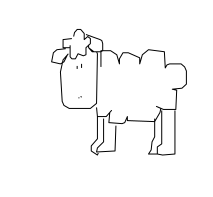

In [134]:
fig, ax = plt.subplots(figsize=(3, 3))

strokes = StrokesPath(a)

patch = patches.PathPatch(strokes, facecolor='none')
ax.add_patch(patch)

x_min, x_max, y_min, y_max = get_bounds(data=a, factor=.2)

ax.set_xlim(x_min-5, x_max+5)
ax.set_ylim(y_max+5, y_min-5)

ax.axis('off')

plt.show()

We define this as a function to maximize modularity and reusability

In [135]:
def draw(stroke, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=stroke,
                                            factor=factor)

    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    strokes = StrokesPath(stroke)

    patch = patches.PathPatch(strokes, facecolor='none')
    ax.add_patch(patch)
    
    ax.axis('off')

Now it is easy to fully take advantage of the functionality provided by Matplotlib to create more complex plots. For example, to draw the sketches in a grid, we just call our draw function on the grid of axes created with `subplots`.

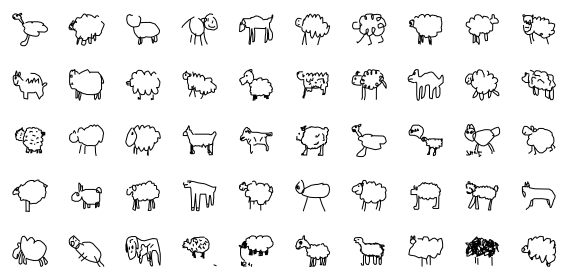

In [136]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for ax_row in ax_arr:
    for ax in ax_row:
        strokes = train_set.random_sample()
        draw(strokes, ax=ax)

plt.show()

#### Explanation

The last column of the 2D array is essentially a binary value that gives the pen action taken prior to the *next* stroke in the sequence.

In [137]:
a[::,-1].astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

A `1` means the pen is to be lifted from the current point before being moved to the next point. In terms of SVG Path commands or Matplotlib `Path` codes, this corresponds to the *next* point being preceded by the `m` command or having the `MOVETO` code, respectively. Otherwise, the pen just draws a line to the next point, which means it is preceded by the `l` command or has the `LINETO` code.

Our `to_code` static method above simply turns the pen action for the next state to the corresponding Matplotlib `Path` code.

In [138]:
{c: getattr(Path, c) for c in dir(Path) if c.isupper()}

{'CLOSEPOLY': 79,
 'CURVE3': 3,
 'CURVE4': 4,
 'LINETO': 2,
 'MOVETO': 1,
 'NUM_VERTICES_FOR_CODE': {0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 79: 1},
 'STOP': 0}

In [139]:
StrokesPath.to_code(a[::,-1].astype(int))

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1])

As explained, the $i$th code is meant for the $i+1$th vertex, so we are not done just yet. We must right shift the array by 1. But what do we do with the first and last elements of the sequence?

Note that the pen action for all stroke sequences are terminated with the pen being lifted. This corresponds to the next vertex having a `MOVETO` code. However, there are no vertices left, so this is superfluous and may be discarded.

In [140]:
all(StrokesPath.to_code(a[-1,-1]) == Path.MOVETO \
    for a in train_set.strokes)

True

On the other hand, the first vertex is always required to have a `MOVETO` code (otherwise, where the drawing actually begins is not well-defined). Therefore, the most simple and elegant solution is just to `np.roll` the array to right by 1, so the first code takes on the value of the last code, which is always a `MOVETO`.

Lastly, while SVG Paths supports both absolute positions and relative offsets (with `M` and `m` commands respectively), Matplotlib only supports absolute positions. As the datasets gives the points as relative offsets, we convert it to absolute positions simply by calling taking the cumulative sum with `np.cumsum`.